In [15]:
# imports
import matplotlib.pyplot as plt 
import scipy
from scipy import stats
import numpy as np
import pandas as pd
from datetime import datetime 
import netCDF4
import xarray as xr
from scipy.stats import binned_statistic, binned_statistic_2d, binned_statistic_dd

# process mms datafiles
import glob
import sys

# append a new directory to sys.path
# sys.path.append('../imef/data/')
# import download_data as ddat

import data_prep as dpp

from matplotlib.patches import Circle
from matplotlib.patches import Wedge
from matplotlib.ticker import MultipleLocator, AutoMinorLocator
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

In [3]:
##

# np.nanmax(dpp.dat_mms1['MLT'].values)

# edi_xarr = dpp.dat_mms1['E_EDI'].loc[:,'x'].name
# edi_xarr[2:]

##

# dpp.dat_mms1.where(abs(dpp.dat_mms1['E_EDP'].loc[:,'x']) >= 1000.) == np.nan
# edi_xarr = edi_xarr.mask(abs(edi_xarr) >= 1000)
# plt.plot(t_xarr, edi_xarr.loc[:,'x'])



In [4]:
# efield_instr = 'E_DIS'
# coord = 'x'
# mlt_ang_adj = 1. / 24.0 * (2.0 * np.pi)

# edi_xarr = dpp.dat_mms1[efield_instr].loc[:,coord].values
# nan_mask = np.ma.masked_where(edi_xarr==np.nan, edi_xarr )

# ll = dpp.dat_mms1['L'].values
# mlt = dpp.dat_mms1['MLT'].values * mlt_ang_adj

# new_l = np.ma.masked_where(np.ma.getmask(nan_mask), ll)
# new_mlt = np.ma.masked_where(np.ma.getmask(nan_mask), mlt)

# print(np.ma.compressed(nan_mask))

In [5]:
# # get radial component 
# # r = sqrt(x^2 + y^2 + z^2)
# x_mms = dpp.dat_mms1['R_sc'].loc[:,'x'].values
# y_mms = dpp.dat_mms1['R_sc'].loc[:,'y'].values
# z_mms = dpp.dat_mms1['R_sc'].loc[:,'z'].values
# rad_dist = np.sqrt(x_mms**2 + y_mms**2+ z_mms**2)

# RE_km = 6371            # earths radius [km]
# np.nanmax(x_mms)/RE_km

In [6]:
def add_offscale_RE(ax, lmax, offset=0.1, half=False, **kwargs):

    """
    Draws offscale RE axis on polar plot.
    Based on stack overflow question 16605137.
    """
    # offset below plot
    # offset = 0.15

    # create new axis and set postion
    rect = ax.get_position()

    if half == True:
        rect = (
            rect.xmin + rect.width / 2,
            rect.ymin - offset,
            rect.width / 2,
            rect.height,
        )
    else:
        rect = (
            rect.xmin,
            rect.ymin - offset,
            rect.width,
            rect.height / 2,
        )

    r_ax = ax.figure.add_axes(rect)

    # hide un-needed elements
    for loc in ["right", "left", "top"]:
        r_ax.spines[loc].set_visible(False)
        r_ax.tick_params(left=False, labelleft=False)
        r_ax.patch.set_visible(False)

    # set axis limits
    # r_ax.set_xlim([0,lmax])
    ticks = np.arange(0, lmax + 1, 2) if half == True else np.arange(-lmax, lmax + 1, 2)
    plt.xticks(ticks, [abs(i) for i in ticks])

    # initialize minor ticks
    r_ax.minorticks_on()
    r_ax.xaxis.set_minor_locator(MultipleLocator(1))

    # remove y-axis minor ticks
    r_ax.yaxis.set_tick_params(which="minor", bottom=False)

    # stylizing
    r_ax.spines["bottom"].set_linestyle("dotted")
    r_ax.tick_params(axis="x", length=8, which="major", direction="inout", **kwargs)
    r_ax.tick_params(axis="x", length=5, which="minor", direction="inout", **kwargs)
    r_ax.set_xlabel("[$R_E$]")

In [7]:
def draw_earth(ax, rad=1, angle=0, ecolor="w", polar=False, style=False, **kwargs):
    """
    A handy function for drawing stylistic dayside/nightside Earth on either cartesian or polar axis.
    Built upon M. Argall's draw_earth.

    Args:
        ax (axis): current axis
        rad (float): radius of projected Earth. If units [RE], use 1. Defaults to 1.
        angle (int, optional): rotation in [deg]. Defaults to 0.
        ecolor (str, optional): color of earth. Defaults to 'w' (white).
        polar (bool, optional): choice of prjection on cartesian (False) or polar (True) axis. Defaults to False.
        style (bool, optional): turns on monotone hatch styling. Defaults to False.
    """

    theta1 = 90 + angle
    theta2 = 270 + angle

    hstyle = "/////"

    # plot on cartesian axis
    if polar == False:

        loc = (0, 0)

        # create semicircles
        dayside = Wedge(
            loc, rad, theta1, theta2, facecolor=ecolor, edgecolor="k", **kwargs
        )
        nightside = Wedge(
            loc, rad, theta2, theta1, facecolor="k", edgecolor="k", **kwargs
        )

        # plot
        ax.add_artist(dayside)
        ax.add_artist(nightside)

    # plot on polar axis
    else:

        # fill color
        dayside = ax.fill_between(
            np.linspace(np.radians(theta1), np.radians(theta2), 30),
            0,
            np.ones(30) * rad,
            color=ecolor,
            **kwargs
        )
        nightside = ax.fill_between(
            np.linspace(-np.radians(theta1), np.radians(theta1), 30),
            0,
            np.ones(30) * rad,
            color="k",
            **kwargs
        )

        # outline
        ax.plot(
            np.linspace(np.radians(theta1), np.radians(theta2), 30),
            np.ones(30) * rad,
            color="k",
            **kwargs
        )
        ax.plot(
            np.linspace(-np.radians(theta1), np.radians(theta1), 30),
            np.ones(30) * rad,
            color="k",
            **kwargs
        )

    # hatch style shading
    if style == True:
        nightside.set_fc(ecolor)
        nightside.set_hatch(hstyle)

/var/folders/8l/y30_j6_97qj5rc4x992936vr0000gp/T/ipykernel_5279/1217222779.py:52: RuntimeWarning: divide by zero encountered in log
  stat = np.log(stat)
/var/folders/8l/y30_j6_97qj5rc4x992936vr0000gp/T/ipykernel_5279/1217222779.py:52: RuntimeWarning: divide by zero encountered in log
  stat = np.log(stat)


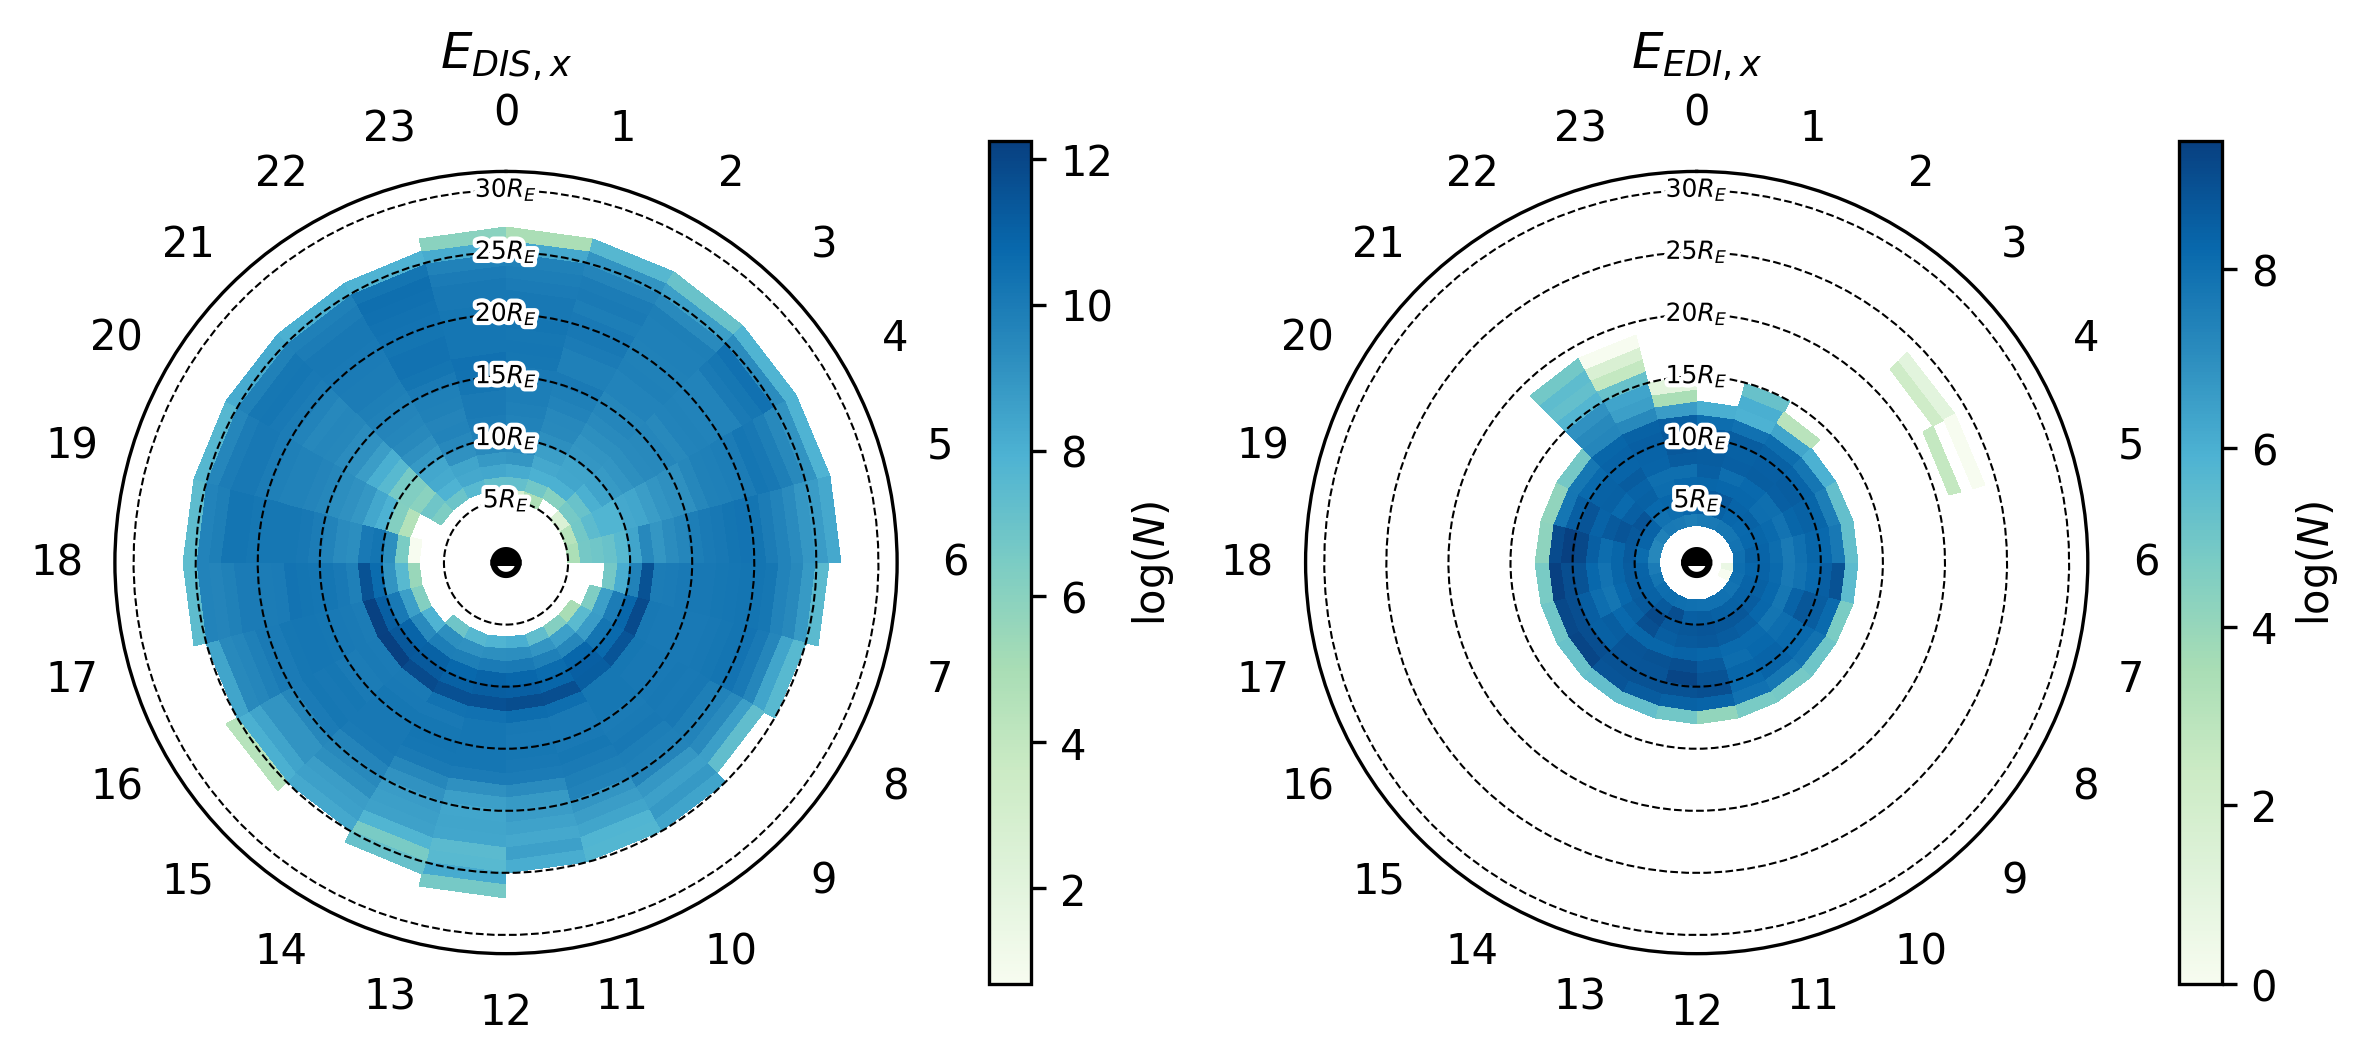

In [29]:
from scipy import stats
import matplotlib.patheffects as pe
def plot_efield_counts_map(ax, mms_dataset, instr='E_DIS', coord='x', uselog=True):

    # constants and constraints 
    RE_km = 6371                                # radius of Earth in units [km]
    radial_max = 30                             # max radial component in units [RE]
    mlt_ang_adj = 1. / 24.0 * (2.0 * np.pi)     # MLT conversion

    # function to get indices of array that are non nans
    def get_non_nan_inds(arr):
        return np.where( ~np.isnan(arr) )[0]

    # mms_dataset = dpp.dat_mms1                  # dataset containing EF [xarray]
    # instr = 'E_DIS'                             # instrument to bin
    # coord = 'x'                                 # cooridnate 
    
    efield_dat = mms_dataset[instr].loc[:,coord].values    # pull e-field data
    ll = mms_dataset['L'].values                           # pull L data
    mlt = mms_dataset['MLT'].values * mlt_ang_adj          # pull MLT data
    lat = mms_dataset['MLAT'].values * mlt_ang_adj         # pull MLAT data

    # get radial component via spacecract position
    # r = sqrt(x^2 + y^2)
    x_mms = mms_dataset['R_sc'].loc[:,'x'].values # x-coordinate in units [km]
    y_mms = mms_dataset['R_sc'].loc[:,'y'].values # y-coordinate in units [km]
    z_mms = mms_dataset['R_sc'].loc[:,'z'].values # z-coordinate in units [km]
    rad_dist = np.sqrt(x_mms**2 + y_mms**2+ z_mms**2) # compute r in units [km]
    rad_dist = rad_dist/RE_km # convert to units [RE]

    # get indices of non-nan values to only count data that exists
    inds = get_non_nan_inds(efield_dat)

    # pull data != nan
    new_ef = efield_dat[inds]
    new_l = ll[inds]
    new_mlt = mlt[inds]
    new_lat = lat[inds]
    new_r = rad_dist[inds]

    # arrange grid
    l_bins = np.arange(0,radial_max,1)
    r_bins = np.arange(0,radial_max,1)
    mlt_bins = np.arange(0, 25, 1) * mlt_ang_adj

    # compute binned 2D histogram of counts (stat) of EF per L, MLT
    stat, xedges, yedges, binnum = stats.binned_statistic_2d(new_r, new_mlt, new_ef, 'count', bins=[r_bins, mlt_bins])
    XX, YY = np.meshgrid(xedges, yedges)

    # find the log of counts
    if uselog==True:
        stat = np.log(stat)

    #2D polar plot
    polarplot = ax.pcolormesh(YY,XX,stat.T,cmap='GnBu')
    fig.colorbar(polarplot,  fraction=0.046, pad=0.1, label='log($N$)')


    ax.set_xticks(np.linspace(0, 2*np.pi, 24, endpoint=False)) # set the circumference labels
    ax.set_xticklabels(range(24))       # set angular axis to MLT range                              
    ax.set_theta_direction(-1)          # make the labels go clockwise     
    ax.set_theta_offset(np.pi/2.0)      # place 0 at the top 
    ax.set_rlabel_position(90)          # change radial axis label positiob

    ax.set_yticklabels([]) # removes standard radial ticks
    ax.set_title('$E_{'+instr[2:]+','+coord+'}$')
    plot_earth = draw_earth(ax, rad=1, angle=0, ecolor="w", polar=True, style=False)
    #add_offscale_RE(ax, radial_max, offset=-0.33, half=True) # offset=-0.35



    def add_labled_circle(circle_radius, circle_color='k'):
        ax.plot(np.linspace(0, 2*np.pi, 100), 
                np.ones(100)*circle_radius, 
                color=circle_color,
                linewidth=0.5, 
                linestyle='--')
        line_offset = 0#2
        text_loc = circle_radius-line_offset
        ax.text(np.pi*0, text_loc, 
                str(circle_radius)+'$R_E$', 
                color=circle_color,
                fontsize=6,
                horizontalalignment='center',
                verticalalignment='center',
                path_effects=[pe.withStroke(linewidth=2, foreground='w')])

    # remove base radial ticks
    ax.set_yticks([])

    # add new ones
    for rloc in range(5,35,5):
        add_labled_circle(rloc, circle_color='k')


    # mark 
    #  L=(6,10) and MLT=(21,3) 
    # flow breaking region where injections and dipolarizing 
    # flux bundles deposit their energy.


    ax.grid(False)
    


fig, ax = plt.subplots(1,2, subplot_kw=dict(projection="polar"), figsize=(8,8), dpi=300)
p1 = plot_efield_counts_map(ax[0], dpp.dat_mms1, instr='E_DIS', coord='x', uselog=True)
p2 = plot_efield_counts_map(ax[1], dpp.dat_mms1, instr='E_EDI', coord='x', uselog=True)
fig.tight_layout()

#plt.savefig("squares3.svg", format="svg") 


In [ ]:
# # for one circle (whole thing commented)

# from scipy import stats

# # constants and constraints 
# RE_km = 6371            # earths radius [km]
# radial_max = 30         # max radial component in units [RE]

# def get_non_nan_inds(arr):
#     return np.where( ~np.isnan(arr) )[0]


# mms_dataset = dpp.dat_mms1                  # dataset containing EF [xarray]
# instr = 'E_DIS'                             # instrument to bin
# coord = 'x'                                 # cooridnate 
# mlt_ang_adj = 1. / 24.0 * (2.0 * np.pi)     # MLT conversion

# efield_dat = mms_dataset[instr].loc[:,coord].values    # pull EF data
# ll = mms_dataset['L'].values                           # pull L data
# mlt = mms_dataset['MLT'].values * mlt_ang_adj          # pull MLT data
# lat = mms_dataset['MLAT'].values * mlt_ang_adj         # pull MLAT data

# # get radial component 
# # r = sqrt(x^2 + y^2)
# x_mms = dpp.dat_mms1['R_sc'].loc[:,'x'].values # x-coordinate in units [km]
# y_mms = dpp.dat_mms1['R_sc'].loc[:,'y'].values # y-coordinate in units [km]
# z_mms = dpp.dat_mms1['R_sc'].loc[:,'z'].values # z-coordinate in units [km]
# rad_dist = np.sqrt(x_mms**2 + y_mms**2+ z_mms**2) # compute r in units [km]
# rad_dist = rad_dist/RE_km # convert to units [RE]

# # efield_dat = get_not_nan(efield_dat)

# # nan_mask = np.ma.masked_where(efield_dat==np.nan, efield_dat) # filter out nans in EF data
# # # apply the mask (nan_mask) on L, MLT
# # new_l = np.ma.masked_where(np.ma.getmask(nan_mask), ll)  
# # new_mlt = np.ma.masked_where(np.ma.getmask(nan_mask), mlt) 

# # get ineices of non nan values
# inds = get_non_nan_inds(efield_dat)

# # pull data != nan
# new_ef = efield_dat[inds]
# new_l = ll[inds]
# new_mlt = mlt[inds]
# new_lat = lat[inds]
# new_r = rad_dist[inds]

# # arrange grid
# l_bins = np.arange(0,radial_max,1)
# r_bins = np.arange(0,radial_max,1)
# mlt_bins = np.arange(0, 25, 1) * mlt_ang_adj #* 2 * np.pi / 24

# # compute binned 2D histogram of counts of EF per L, MLT
# stat, xedges, yedges, binnum = stats.binned_statistic_2d(new_r, new_mlt, new_ef, 'count', bins=[r_bins, mlt_bins])
# XX, YY = np.meshgrid(xedges, yedges)

# stat=np.log(stat)


# # # plot 2D cartesian plot
# # fig = plt.figure()
# # ax  = plt.subplot(111)
# # cart_plot = ax.pcolormesh(XX,YY,stat.T)
# # cbar = plt.colorbar(cart_plot,ax=ax, pad = .015, aspect=10) # colorbar
# # plt.xlabel('L')
# # plt.ylabel('MLT')
# # plt.show()

# # plot 2D polar plot
# fig, ax = plt.subplots(subplot_kw=dict(projection="polar"), dpi=300)
# polarplot = ax.pcolormesh(YY,XX,stat.T,cmap='GnBu')
# fig.colorbar(polarplot,  fraction=0.046, pad=0.1, label='log($N$)')


# ax.set_xticks(np.linspace(0, 2*np.pi, 24, endpoint=False)) # set the circumference labels
# ax.set_xticklabels(range(24))       # set angular axis to MLT range                              
# ax.set_theta_direction(-1)          # make the labels go clockwise     
# ax.set_theta_offset(np.pi/2.0)      # place 0 at the top 
# ax.set_rlabel_position(90)          # change radial axis label positiob

# #ax.set_yticklabels([]) # removes standard radial ticks
# ax.set_title('$E_{'+instr[2:]+','+coord+'}$')
# plot_earth = draw_earth(ax, rad=1, angle=0, ecolor="w", polar=True, style=False)
# #add_offscale_RE(ax, radial_max, half=True) # offset=-0.35

# ax.grid(False)

# #plt.savefig("squares2", format="svg") 


In [ ]:
# def get_not_nan(np_arr):
#     not_nan_mask = ~np.isnan(np_arr)
#     return np_arr[ not_nan_mask ]

In [ ]:
# error
width = 2.5
filtr_dist =  df_coord[(df_coord['EDI_'+ef_coord] <= 2) & (df_coord['EDI_'+ef_coord] >= -2) & df_coord['EDI_'+ef_coord].notna()]

print(filtr_dist.quantile([0.25,0.5,0.75, 0.85]))
qlim = 0.116613

# calculate IQR
q_upper = 0.98 # x,y,z = [?,?,0.98]
q_lower = 0.02 # x,y,z = [?,?,0.02]
Q1 = filtr_dist['EDP_'+ef_coord].quantile(q_lower)
Q3 = filtr_dist['EDP_'+ef_coord].quantile(q_upper)
IQR = Q3 - Q1

# identify outliers
threshold = 1.5
outs = filtr_dist[(filtr_dist['EDP_'+ef_coord] < Q1 - threshold * IQR) | (filtr_dist['EDP_'+ef_coord] > Q3 + threshold * IQR)]

# outs =  filtr_dist[(filtr_dist['EDP_z'] <= qlim) & (filtr_dist['EDP_z'] >= -1*qlim)]
plt.scatter(df_coord['EDI_'+ef_coord], df_coord['EDP_'+ef_coord])
plt.scatter(outs['EDI_'+ef_coord], outs['EDP_'+ef_coord])
plt.xlabel("EDI_"+ef_coord)
plt.ylabel("EDP_"+ef_coord)
plt.title(f"Q-UPPER: {q_upper}, Q-LOWER: {q_lower}")

NameError: name 'df_coord' is not defined

In [ ]:
edi = dpp.dat_mms1['E_EDI']
edp = dpp.dat_mms1['E_EDP'][:,:,0].drop(['cart',]).rename({'E_index': 'cart'}).assign_coords({'cart': ['x', 'y', 'z']}) # (A/N): correct units
dis = dpp.dat_mms1['E_DIS']
t = dpp.dat_mms1['time']

print(max(edp.loc[:,'x'].values))

for arr in edp.values:
    arr[abs(arr) >= 1000] = np.nan

for arr in edi.values:
    arr[abs(arr) >= 1000] = np.nan

IndexError: too many indices

In [ ]:
def replace_outliers(data, dim=0, perc=0.99):

  # calculate percentile 
  threshold = data[dim].quantile(perc)

  # find outliers and replace them with max among remaining values 
  mask = data[dim].where(abs(data[dim]) <= threshold)
  max_value = mask.max().values
  # .where replace outliers with nan
  mask = mask.fillna(max_value)
  print(mask)
  data[dim] = mask

  return data

replace_outliers(edp.loc[:,'x'])

plt.plot(t.values,edp.loc[:,'x'].values)

NameError: name 'edp' is not defined

In [ ]:
print(max(edp.loc[:,'x'].values))

nan


         EDI_z     EDP_z         time
0.25 -0.861616 -0.290515  28922398.75
0.50 -0.220091  0.020282  57844797.50
0.75  0.505623  0.349278  86767196.25
0.85  0.986362  0.756361  98336155.75


Text(0.5, 1.0, 'Q-UPPER: 0.98, Q-LOWER: 0.02')

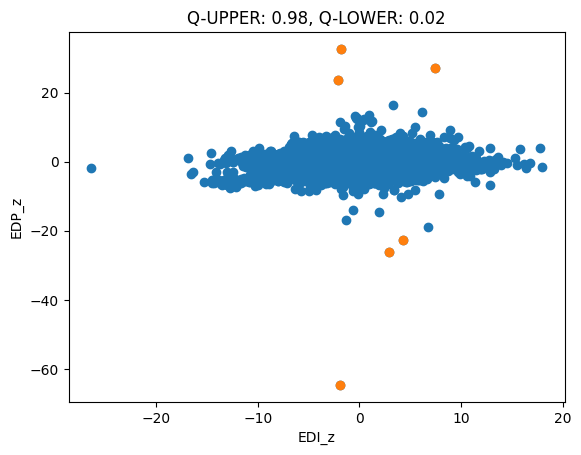

In [ ]:
# observing outliers; pull specific coordinates
ef_coord = 'z' # specified coordinate
edi_coord = edi.loc[:,ef_coord].values
edp_coord = edp.loc[:,ef_coord].values
dis_coord = dis.loc[:,ef_coord].values

# remove outlying values
for arr in [edi_coord, edp_coord]:
    arr[abs(arr) >= 100] = np.nan

# create datafrane (df) for E-Field coordinate    
newdat = {'EDI_'+ef_coord: edi_coord, 'EDP_'+ef_coord: edp_coord, 'time': t}
df_coord = pd.DataFrame(data=newdat)
df_coord.head(5) # check


# filter dataframe to be only +/- width value in [mV/m] of EDI
# (this is where EDP outliers are)
width = 2.5
filtr_dist =  df_coord#[(df_coord['EDI_'+ef_coord] <= 2) & (df_coord['EDI_'+ef_coord] >= -2) & df_coord['EDI_'+ef_coord].notna()]

print(filtr_dist.quantile([0.25,0.5,0.75, 0.85]))
qlim = 0.116613

# calculate IQR
q_upper = 0.98 # x,y,z = [?,?,0.98]
q_lower = 0.02 # x,y,z = [?,?,0.02]
Q1 = filtr_dist['EDP_'+ef_coord].quantile(q_lower)
Q3 = filtr_dist['EDP_'+ef_coord].quantile(q_upper)
IQR = Q3 - Q1

# identify outliers
threshold = 1.5
outs = filtr_dist[(filtr_dist['EDP_'+ef_coord] < Q1 - threshold * IQR) | (filtr_dist['EDP_'+ef_coord] > Q3 + threshold * IQR)]

# outs =  filtr_dist[(filtr_dist['EDP_z'] <= qlim) & (filtr_dist['EDP_z'] >= -1*qlim)]
plt.scatter(df_coord['EDI_'+ef_coord], df_coord['EDP_'+ef_coord])
plt.scatter(outs['EDI_'+ef_coord], outs['EDP_'+ef_coord])
plt.xlabel("EDI_"+ef_coord)
plt.ylabel("EDP_"+ef_coord)
plt.title(f"Q-UPPER: {q_upper}, Q-LOWER: {q_lower}")



NameError: name 'df_pot' is not defined

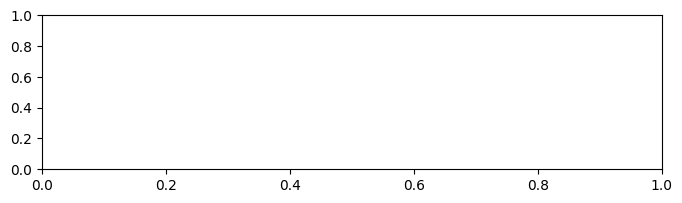

In [ ]:
# find outliers that fall outside IQR
tf = df_coord['time'].isin(outs['time'])
df_coord['Outs'] = tf
nbool = np.zeros(len(df_coord["time"]))
df_coord['Outs'] = df_coord['Outs'].astype(int) # converts True/False to 1/0 for shading plot
# overview plot 

fig, ax = plt.subplots(1, figsize=(8, 2))

# plot aspoc data
# plt.plot(df_pot["time"], df_pot["ionic"], zorder=10, alpha=0.5, label='mms1_aspoc_ionic [uA]')
plt.plot(df_pot["time"], df_pot["asp1_en"], zorder=10, alpha=0.5, label='mms1_asp1_energy')

# plot edp data
ax.plot(df_coord['time'], df_coord['EDP_'+ef_coord], label='edp')

ax.fill_between(df_coord['time'], 0, 1, 
                        where=df_coord["Outs"], 
                        alpha=0.25,
                        color='r', 
                        transform=ax.get_xaxis_transform(),
                        label = "True", zorder=20)

# x-axis tick label rotation to fit length of date
# ax.set_xticks(ax.get_xticks().tolist())
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

# from datetime import date
st_dt = '2017-06-01 00:00:00'
ed_dt = '2017-08-01 08:00:00'
ax.set_xlim(pd.Timestamp(st_dt), pd.Timestamp(ed_dt))

ax.legend()

In [40]:
from matplotlib import pyplot as plt, dates as mdates, ticker
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


def add_colorbar(ax, im, wpad=1.05):
    '''
    Add a colorbar to the axes.
    Parameters
    ----------
    ax : `matplotlib.axes.Axes`
        Axes to which the colorbar is attached.
    im : `matplotlib.axes.Axes.pcolorfast`
        The image that the colorbar will represent.
    '''
    cbaxes = inset_axes(ax,
                        width='2%', height='100%', loc=4,
                        bbox_to_anchor=(0, 0, wpad, 1),
                        bbox_transform=ax.transAxes,
                        borderpad=0)
    cb = plt.colorbar(im, cax=cbaxes, orientation='vertical')
    cb.ax.minorticks_on()

    return cb


def add_legend(ax, lines=None, corner='NE', outside=False, horizontal=False, title=None):
    '''
    Add a legend to the axes. Legend elements will have the same color as the
    lines that they label.
    Parameters
    ----------
    ax : `matplotlib.axes.Axes`
        Axes to which the legend is attached.
    lines : list of `matplotlib.lines.Line2D`
        The line elements that the legend format should match
    corner : str
        The bounding box of the legend will be tied to this corner:
        ('NE', 'NW', 'SE', 'SW')
    outside : bool
        The bounding box will extend outside the plot
    horizontal : bool
        The legend items will be placed in columns (side-by-side) instead of
        rows (stacked vertically)
    '''

    if horizontal:
        ncol = len(lines)
        columnspacing = 0.5
    else:
        ncol = 1
        columnspacing = 0.0

    if corner == 'NE':
        bbox_to_anchor = (1, 1)
        loc = 'upper left' if outside else 'upper right'
    elif corner == 'SE':
        bbox_to_anchor = (1, 0)
        loc = 'lower left' if outside else 'lower right'
    elif corner == 'NW':
        bbox_to_anchor = (0, 1)
        loc = 'upper right' if outside else 'upper left'
    elif corner == 'SW':
        bbox_to_anchor = (0, 0)
        loc = 'lower right' if outside else 'lower left'

    leg = ax.legend(bbox_to_anchor=bbox_to_anchor,
                    borderaxespad=0.0,
                    columnspacing=columnspacing,
                    frameon=False,
                    handlelength=1,
                    handletextpad=0.25,
                    loc=loc,
                    ncol=ncol,
                    title=title)


#    for line, text in zip(lines, leg.get_texts()):
#        text.set_color(line.get_color())


def draw_earth_cart(ax):
    '''
    A handy function for drawing the Earth in a set of cartesian axes
    '''
    N = 30
    r = np.ones(N)

    # Closed semi-circile on night-side
    theta = np.linspace(-np.pi / 2, np.pi / 2, N)
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    ax.fill_betweenx(y, x, np.zeros(N), color='k')

    #  Open semi-circle on dayside
    theta = np.linspace(np.pi / 2, 3 * np.pi / 2, N)
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    ax.plot(x, y, color='k')


def draw_earth_pol(ax):
    '''
    A handy function for drawing the Earth in a set of Polar Axes
    '''
    ax.fill_between(np.linspace(-np.pi / 2, np.pi / 2, 30), 0, np.ones(30), color='k')
    ax.plot(np.linspace(np.pi / 2, 3 * np.pi / 2, 30), np.ones(30), color='k')


def format_axes(ax, xaxis=True, yaxis=True, time=True):
    '''
    Format the abcissa and ordinate axes
    Parameters
    ----------
    ax : `matplotlib.pyplot.Axes`
        Axes to be formatted
    time : bool
        If true, format the x-axis with dates
    xaxis, yaxis : str
        Indicate how the axes should be formatted. Options are:
        ('on', 'time', 'off'). If 'time', the ConciseDateFormatter is applied
        If 'off', the axis label and ticklabels are suppressed. If 'on', the
        default settings are used
    '''
    locator = mdates.AutoDateLocator()
    formatter = mdates.ConciseDateFormatter(locator)

    # All x-axes should be formatted with time
    if time:
        ax.xaxis.set_major_locator(locator)
        ax.xaxis.set_major_formatter(formatter)
        ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
        for tick in ax.get_xticklabels():
            tick.set_rotation(45)
    else:
        ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())

    if not xaxis:
        ax.set_xticklabels([])
        ax.set_xlabel('')

    if ax.get_yscale() == 'log':
        locmaj = ticker.LogLocator(base=10.0)
        ax.yaxis.set_major_locator(locmaj)

        locmin = ticker.LogLocator(base=10.0, subs=(0.3, 0.6, 0.9))
        ax.yaxis.set_minor_locator(locmin)
        ax.yaxis.set_minor_formatter(ticker.NullFormatter())
    else:
        ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())

    if not yaxis:
        ax.set_yticklabels([])
        ax.set_ylabel('')
def plot_global_counts_one(counts, axes=None):
    if axes is None:
        fix, axes = plt.subplots(nrows=1, ncols=1, squeeze=False,
                                 subplot_kw=dict(projection='polar'))
        ax = axes[0, 0]
    else:
        ax = axes
        fig = ax.figure

    log_counts = np.ma.log(counts)

    im = ax.pcolormesh(counts['theta'], counts['r'], log_counts,
                       cmap='YlOrRd', shading='auto')
    ax.set_thetagrids(np.linspace(0, 360, 9), labels=['0', '3', '6', '9', '12', '15', '18', '21', ' '])
    ax.set_xlabel("log$_{10}$(Counts)")

    draw_earth_pol(ax)

    add_colorbar(ax, im, wpad=1.3)

    return fig, axes

def plot_global_efield_one(E, counts, axes=None, plot_counts=False):
    '''
    Create a polar plot of the Electric field vectors binned in (r, theta) space.

    Parameters
    ----------
    ds : `xarray.Dataset`
        Data to be plotted, including the r and theta bins.
    varname : str
        Name of the variable to be plotted

    Returns
    -------
    fig : matplotlib figure
        Figure object
    axes : matplotlib subplots
        Axes in which the counts and electric field are plotted
    '''
    # Create the axes
    if axes is None:
        # Number of columns
        #   - Irrelevant if axes is given
        ncols = 1
        if plot_counts:
            ncols = 2

        # Create the figure
        fig, axes = plt.subplots(nrows=1, ncols=ncols, squeeze=False, figsize=(6.5, 4),
                                 subplot_kw=dict(projection='polar'))
        plt.subplots_adjust(wspace=0.33, bottom=0.15, right=0.85)

        # Assign the axes
        ax = axes[0, 0]
        if plot_counts:
            ax_cts = axes[0, 1]

    # Axes were given
    else:

        # Assign the axes
        if plot_counts:
            ax = axes[0]
            ax_cts = axes[1]
        else:
            ax = axes

        # Get the figure
        fig = ax.figure

    # Global Electric Field
    ax.quiver(E['theta'], E['r'], E['E_con_mean'][..., 0], E['E_con_mean'][..., 1])
    # ax.quiver(E['theta'], E['r'], E[..., 0], E[..., 1])
    ax.set_xlabel("Electric Field")
    ax.set_thetagrids(np.linspace(0, 360, 9), labels=['0', '3', '6', '9', '12', '15', '18', '21', ' '])
    ax.set_theta_direction(1)

    # Draw the earth
    draw_earth_pol(ax)

    # Counts
    if plot_counts:
        plot_global_counts_one(counts[..., 0], axes=ax_cts)

    return fig, axes

        
def plot_global_efield_kp(ds, varname='E_EDI_corot'):
    '''
    Create a polar plot of the Electric field vectors binned in (r, theta) space.

    Parameters
    ----------
    ds : `xarray.Dataset`
        Data to be plotted, including the r and theta bins.
    varname : str
        Name of the variable to be plotted

    Returns
    -------
    fig : matplotlib figure
        Figure object
    axes : matplotlib subplots
        Axes in which the counts and electric field are plotted
    '''

    fig, axes = plt.subplots(nrows=3, ncols=3, squeeze=False, figsize=(7, 7),
                             subplot_kw=dict(projection='polar'))
    plt.subplots_adjust(wspace=0.6, hspace=0.65, bottom=0.1)

    for idx, E in enumerate(ds[varname + '_mean']):
        irow = idx // 3
        icol = idx % 3
        ax = axes[irow, icol]

        ax_title = 'kp=[{0},{1}-]'.format(np.ceil(ds['kp'][idx].data),
                                          np.ceil(ds['kp'][idx].data) + 1)

        plot_global_efield_one(E, ds[varname + '_counts'][idx, ...],
                               axes=ax, plot_counts=False)

        ax.set_title(ax_title)

        if ~ax.is_last_row():
            ax.set_xlabel('')
        #            ax.set_xticklabels([])

        if ~ax.is_first_col():
            ax.set_ylabel('')

    # Last plot
    ax = axes[-1, -1]
    ax.set_title('Kp=[0,9-]')
    ax.set_xlabel('')

    # Average over the remaining theta bins
    data = xr.DataArray(np.ma.average(ds[varname + '_mean'].to_masked_array(), axis=0,
                                      weights=ds[varname + '_counts']),
                        dims=('r', 'theta', 'comp'),
                        coords={'r': ds['r'],
                                'theta': ds['theta'],
                                'comp': ds['comp']})

    # Sum all counts over the theta dimension
    cts = np.sum(ds[varname + '_counts'], axis=0)
    cts = cts.where(cts != 0)

    plot_global_efield_one(data, cts,
                           axes=ax, plot_counts=False)

    return fig, axes

KeyError: 'theta'

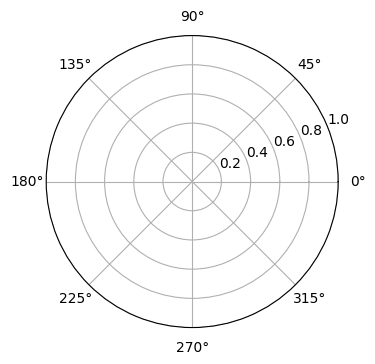

In [43]:
mms_dataset = dpp.dat_mms1
dL = mms_dataset['L']
dE = mms_dataset['E_EDI']
counts=1


plot_global_efield_one(dE, counts, axes=None, plot_counts=False)

In [ ]:
from scipy import stats
import matplotlib.patheffects as pe

def plot_efield_dist_map(ax, mms_dataset,  instr='E_DIS', coord='x', uselog=True):

    # constants and constraints 
    RE_km = 6371                                # radius of Earth in units [km]
    radial_max = 30                             # max radial component in units [RE]
    mlt_ang_adj = 1. / 24.0 * (2.0 * np.pi)     # MLT conversion

    # function to get indices of array that are non nans
    def get_non_nan_inds(arr):
        return np.where( ~np.isnan(arr) )[0]
    
    efield_dat = mms_dataset[instr].loc[:,coord].values    # pull e-field data
    ll = mms_dataset['L'].values                           # pull L data
    mlt = mms_dataset['MLT'].values * mlt_ang_adj          # pull MLT data
    lat = mms_dataset['MLAT'].values * mlt_ang_adj         # pull MLAT data

    # get radial component via spacecract position
    # r = sqrt(x^2 + y^2)
    x_mms = mms_dataset['R_sc'].loc[:,'x'].values # x-coordinate in units [km]
    y_mms = mms_dataset['R_sc'].loc[:,'y'].values # y-coordinate in units [km]
    z_mms = mms_dataset['R_sc'].loc[:,'z'].values # z-coordinate in units [km]
    rad_dist = np.sqrt(x_mms**2 + y_mms**2+ z_mms**2) # compute r in units [km]
    rad_dist = rad_dist/RE_km # convert to units [RE]

    # get indices of non-nan values to only count data that exists
    inds = get_non_nan_inds(efield_dat)

    # pull data != nan
    new_ef = efield_dat[inds]
    new_l = ll[inds]
    new_mlt = mlt[inds]
    new_lat = lat[inds]
    new_r = rad_dist[inds]

    # arrange grid
    l_bins = np.arange(0,radial_max,1)
    r_bins = np.arange(0,radial_max,1)
    mlt_bins = np.arange(0, 25, 1) * mlt_ang_adj

    # compute binned 2D histogram of counts (stat) of EF per L, MLT
    stat, xedges, yedges, binnum = stats.binned_statistic_2d(new_r, new_mlt, new_ef, 'count', bins=[r_bins, mlt_bins])
    XX, YY = np.meshgrid(xedges, yedges)

    # find the log of counts
    if uselog==True:
        stat = np.log(stat)

    #2D polar plot
    polarplot = ax.pcolormesh(YY,XX,stat.T,cmap='GnBu')
    fig.colorbar(polarplot,  fraction=0.046, pad=0.1, label='log($N$)')


    ax.set_xticks(np.linspace(0, 2*np.pi, 24, endpoint=False)) # set the circumference labels
    ax.set_xticklabels(range(24))       # set angular axis to MLT range                              
    ax.set_theta_direction(-1)          # make the labels go clockwise     
    ax.set_theta_offset(np.pi/2.0)      # place 0 at the top 
    ax.set_rlabel_position(90)          # change radial axis label positiob

    ax.set_yticklabels([]) # removes standard radial ticks
    ax.set_title('$E_{'+instr[2:]+','+coord+'}$')
    plot_earth = draw_earth(ax, rad=1, angle=0, ecolor="w", polar=True, style=False)
    #add_offscale_RE(ax, radial_max, offset=-0.33, half=True) # offset=-0.35



    def add_labled_circle(circle_radius, circle_color='k'):
        ax.plot(np.linspace(0, 2*np.pi, 100), 
                np.ones(100)*circle_radius, 
                color=circle_color,
                linewidth=0.5, 
                linestyle='--')
        line_offset = 0#2
        text_loc = circle_radius-line_offset
        ax.text(np.pi*0, text_loc, 
                str(circle_radius)+'$R_E$', 
                color=circle_color,
                fontsize=6,
                horizontalalignment='center',
                verticalalignment='center',
                path_effects=[pe.withStroke(linewidth=2, foreground='w')])

    # remove base radial ticks
    ax.set_yticks([])

    # add new ones
    for rloc in range(5,35,5):
        add_labled_circle(rloc, circle_color='k')


    # mark 
    #  L=(6,10) and MLT=(21,3) 
    # flow breaking region where injections and dipolarizing 
    # flux bundles deposit their energy.


    ax.grid(False)
    

In [52]:
v = mms_dataset['E_EDI'].loc[:,'x']
v.size

44184960